In [1]:
%matplotlib inline

import matplotlib
import autograd.numpy as np
import matplotlib.pyplot as plt
import random
import math
from autograd import grad

def generateChevronData():
    xBounds = [-50, 50]
    yBounds = [-50, 50]
    totalPoints = 100
    
    points = []
    targets = []
    
    for i in range(0, totalPoints):
        x = random.randint(xBounds[0], xBounds[1])
        y = random.randint(yBounds[0], yBounds[1])
        
        if x >= y and x <= -y:
            points.append([x/50.0,y/50.0])
            targets.append(0)
        else:
            points.append([x/50.0,y/50.0])
            targets.append(1)
        
    return np.array(points), np.array(targets)
    
def plotScatter(points):
    xs = [x[0] for x in points]
    ys = [y[1] for y in points]
    
    plt.scatter(xs, ys)

In [2]:
def sigmoid(phi):
    return 1.0/(1.0 + np.exp(-phi))

def MSE(weights):
    predictions = logisticPrediction(weights, points)
    w = np.full((len(predictions)), np.log(1/2)) # CONSTANT
    r = responsibility(weights, points)
#     print(r)
    return -np.sum( r * ((targets*np.log(predictions) + (1-targets)*np.log(1-predictions))) + (1-r) * w)

def logisticPrediction(weights, p):
    return np.array(list(map(lambda x: predict(weights, x), p))) 
    
def predict(weights, inputs):
    n = np.array([weights[0], weights[1]])
    i = np.array([weights[2] - inputs[0], weights[3] - inputs[1]])
    return sigmoid(np.dot(n, i))

def responsibility(weights, points):
    r = weights[4]
    a = np.array([weights[2], weights[3]])
    
    dif = np.array(list(map(lambda x: x - a, points)))
    s = np.array(list(map(lambda x: np.sum(np.power(x, 2)), dif)))
    d = np.sqrt(s)
    
    return 1/(1 + np.power(np.e, (10*(d - r))))

In [3]:
def computeGradient(weights, example, target):
    prediction = predict(weights, example)
    r = responsibility(weights, [example])[0]
    dE_dO = computeErrorDifferential(r, prediction, target)
    dE_dr = computeResponsibilityDifferential(weights, example)
    
    dO_dZ = prediction * (1-prediction)
    
#     dZ_d0 = example[0]
    dZ_d1 = (weights[2] - example[0])
    dZ_d2 = (weights[3] - example[1])
    dZ_d3 = weights[0]
    dZ_d4 = weights[1]
    
    dE_dZ = dE_dO * dO_dZ
    
    grad = np.zeros(len(weights))#[0.0, 0.0, 0.0]
#     grad[0] = dZ_d0 * dE_dZ
    grad[0] = dZ_d1 * dE_dZ
    grad[1] = dZ_d2 * dE_dZ
    grad[2] = dZ_d3 * dE_dZ
    grad[3] = dZ_d4 * dE_dZ
    grad[4] = -dE_dr * ((target*np.log(prediction) + (1-target)*np.log(1-prediction)) - np.log(1/2))
#     print(((target*np.log(prediction) + (1-target)*np.log(1-prediction))))
    
    return grad

def computeErrorDifferential(r, prediction, target):
    return -r * (target - prediction)/(prediction - prediction**2)

def computeResponsibilityDifferential(weights, example):
    r = weights[4]
    a = np.array([weights[2], weights[3]])
    
    dif = example - a
    s = np.sum(np.power(dif, 2))
    d = np.sqrt(s)
    
    return (10 * np.power(np.e, (d + r)))/np.power(np.power(np.e, 10*d) + np.power(np.e, 10*r), 2)

In [8]:
def trainBoundaryHunter():
    weights = np.array([0.0, 0.0, 0.0, 0.0, 0.3])
    
    print("Initial Loss: ", MSE(weights))
    for i in range(0, 10000):
        weights = computeStep(weights)
    
        if i % 1000 == 0:
            print("Loss [i = " + str(i) + "]: " + str(MSE(weights)))
            print(weights)
            
    print("Trained Loss: ", MSE(weights))    
    print("Weights: ", weights)
    return weights

def computeStep(weights):
    totalG = np.zeros(len(weights))
    totalE = 0
    for i in range(0, len(points)):
        g = computeGradient(weights, points[i], targets[i])
        totalG += g     
        
#     totalG = totalG * (1/len(points))
    
    weights -= totalG * 0.01
    return weights

Type 0:  35
Type 1:  65
Initial Loss:  69.314718056
Loss [i = 0]: 69.310367697
[-0.00215269 -0.00623677  0.          0.          0.3       ]
Loss [i = 1000]: 64.0775434397
[-0.23490637 -5.56676691 -0.04157897 -0.19374644  0.43118131]
Loss [i = 2000]: 60.6766641419
[ 0.03261602 -8.46412688 -0.04219063 -0.23565505  0.50256874]
Loss [i = 3000]: 62.4852595202
[-0.03957522 -9.12175658 -0.04017502 -0.07375359  0.53985209]
Loss [i = 4000]: 61.405213166
[-0.05322748 -8.62387143 -0.04038251 -0.08981297  0.56261097]
Loss [i = 5000]: 60.9517784478
[-0.07992897 -8.30581967 -0.03833756 -0.0885642   0.57994937]
Loss [i = 6000]: 60.6336692851
[-0.14368232 -8.06027532 -0.03227476 -0.08593014  0.5938009 ]
Loss [i = 7000]: 60.4054332415
[-0.25836958 -7.85477566 -0.02025348 -0.08276289  0.60527437]
Loss [i = 8000]: 60.2413775101
[ -4.50008181e-01  -7.66769093e+00   1.12242889e-03  -7.93054834e-02
   6.15032491e-01]
Loss [i = 9000]: 60.1073749603
[-0.77614455 -7.47807308  0.03918125 -0.0755839   0.6235066

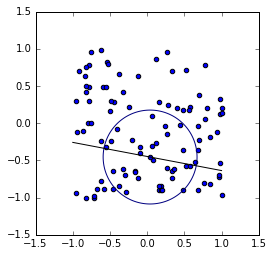

In [9]:
random.seed(1234)
points, targets = generateChevronData()

plt.axis([-1.5, 1.5, -1.5, 1.5])

# Plot points on graph
c1 = []
c2 = []

for i in range(0, len(points)):
    if targets[i] == 0:
        c1.append(points[i])
    else:
        c2.append(points[i])

print("Type 0: ", len(c1))
print("Type 1: ", len(c2))
        
plotScatter(c1)
plotScatter(c2)

weights = trainBoundaryHunter()

# plt.scatter(weights[1], weights[2])
plt.scatter(weights[2], weights[3])

n = np.array([weights[0] * weights[2] + weights[1] * weights[3], 
              -weights[0], 
              -weights[1]])

byas = -1 * n[0]/n[2]
Xcoef = -1 * n[1]/n[2]

x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x,y)
F = ((X - weights[2]))**2 + ((Y - weights[3]))**2 - weights[4]**2
plt.contour(X,Y,F,[0])

# print()
# print(n)
# print("\nLine")
# print("B: " + str(byas))
# print("XCoef: " + str(Xcoef))

plt.plot([-1.0, 1.0], [-1*Xcoef + byas, Xcoef + byas], 'k-')
plt.gca().set_aspect('equal')

plt.show()